In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

KeyboardInterrupt: 

In [2]:
# Tentukan path dan parameter
DATASET_PATH = 'dataset'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # 20% data untuk validasi

# Muat data training
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Muat data validasi
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Dapatkan nama kelas
class_names = train_dataset.class_names
print("Kelas yang ditemukan:", class_names)
num_classes = len(class_names)

# Optimasi performa dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Kelas yang ditemukan: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [5]:
# Tentukan input shape
IMG_SHAPE = IMAGE_SIZE + (3,)

# Muat base model MobileNetV2 (tanpa lapisan klasifikasi atas)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Bekukan bobot base model agar tidak ikut ter-train ulang
base_model.trainable = False

# Rescale pixel values from [0, 255] to [-1, 1] as expected by MobileNetV2
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Buat model akhir dengan perbaikan
model = Sequential([
    # 1. Lapisan Input
    tf.keras.Input(shape=IMG_SHAPE),
    # 2. Augmentasi data
    data_augmentation,
    # 3. PERBAIKAN: Bungkus fungsi preprocessing dengan Lambda Layer
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    # 4. Base model
    base_model,
    # 5. Pooling layer
    GlobalAveragePooling2D(),
    # 6. Dropout untuk regularisasi
    Dropout(0.2),
    # 7. Lapisan output (12 kelas)
    Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 12)               

In [ ]:
# Callback untuk menghentikan training jika val_loss tidak membaik setelah 3 epoch
# dan mengembalikan bobot terbaik yang pernah dicapai.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True
)

# Callback untuk menyimpan hanya model terbaik berdasarkan val_loss
model_checkpoint = ModelCheckpoint(
    MODEL_PATH, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25, # Beri batas epoch yang lebih tinggi, biarkan early stopping yang bekerja
    callbacks=[early_stopping, model_checkpoint] # Tambahkan ini
)

Epoch 1/15
388/388 [==============================] - 256s 604ms/step - loss: 1.7160 - accuracy: 0.4697 - val_loss: 1.0468 - val_accuracy: 0.7170
Epoch 2/15
388/388 [==============================] - 228s 587ms/step - loss: 0.8808 - accuracy: 0.7419 - val_loss: 0.6710 - val_accuracy: 0.8353
Epoch 3/15
388/388 [==============================] - 245s 632ms/step - loss: 0.6501 - accuracy: 0.8113 - val_loss: 0.5297 - val_accuracy: 0.8663
Epoch 4/15
388/388 [==============================] - 237s 611ms/step - loss: 0.5483 - accuracy: 0.8357 - val_loss: 0.4526 - val_accuracy: 0.8859
Epoch 5/15
388/388 [==============================] - 257s 663ms/step - loss: 0.4912 - accuracy: 0.8524 - val_loss: 0.4030 - val_accuracy: 0.8940
Epoch 6/15
388/388 [==============================] - 239s 616ms/step - loss: 0.4479 - accuracy: 0.8605 - val_loss: 0.3731 - val_accuracy: 0.8995
Epoch 7/15
388/388 [==============================] - 231s 594ms/step - loss: 0.4223 - accuracy: 0.8716 - val_loss: 0.3497 -

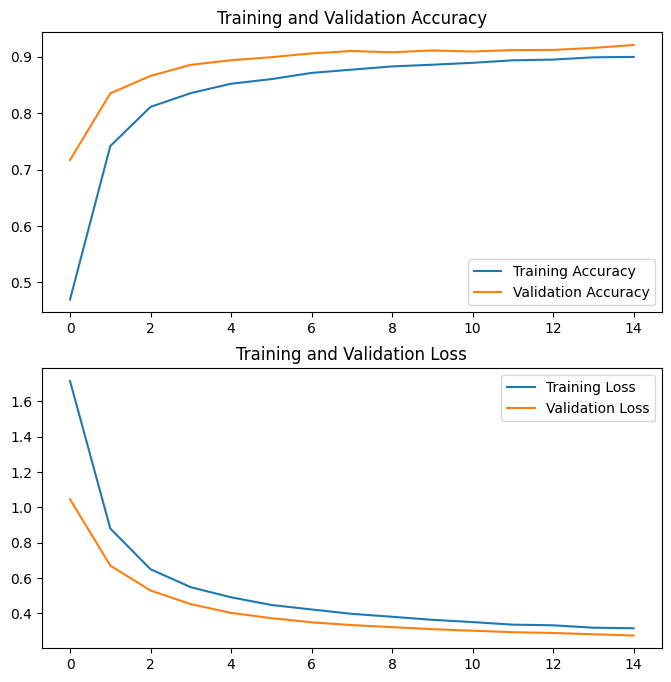

Model berhasil disimpan di: models/garbage_classifier_mobilenetv2.h5


In [ ]:
# Plot akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

MODEL_PATH = 'models/garbage_classifier_v2_earlystop.h5'
model.save(MODEL_PATH)
print(f"Model berhasil disimpan di: {MODEL_PATH}")

# Simpan juga nama kelas untuk digunakan nanti
import pickle
with open('models/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)